In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima.arima import ndiffs
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_55_2201.csv")
house_load_data.columns = ['tmp']
house_load_data[['no', 'time', 'familyID','state','receivingAccumulatedActiveEnergy','sendingAccumulatedActiveEnergy','receivingActivePowery','sendingActivePower','voltage','current','date']] = pd.DataFrame(house_load_data.tmp.str.split(';',11).tolist())
house_load_data.drop('tmp',axis=1,inplace=True)

In [3]:
house_load_data.drop('receivingActivePowery',axis=1,inplace=True)
house_load_data.drop('sendingActivePower',axis=1,inplace=True)
house_load_data.drop('sendingAccumulatedActiveEnergy',axis=1,inplace=True)
house_load_data.drop('voltage',axis=1,inplace=True)
house_load_data.drop('current',axis=1,inplace=True)

In [4]:
house_load_data.head(5)

,no,time,familyID,state,receivingAccumulatedActiveEnergy,date
0,136289650,2022-01-06 12:56:59,55,N,957420,2022-01-06 12:56:59
1,136289691,2022-01-06 12:57:08,55,N,957420,2022-01-06 12:57:08
2,136291190,2022-01-06 13:02:26,55,N,957420,2022-01-06 13:02:26
3,136291462,2022-01-06 13:03:22,55,N,957420,2022-01-06 13:03:22
4,136293502,2022-01-06 13:10:24,55,N,957420,2022-01-06 13:10:24


In [5]:
#시계열 분해법으로 분해(시계열 형태의 ts 데이터 생성)
timeSeries = house_load_data.loc[:,["date","time","receivingAccumulatedActiveEnergy"]]
timeSeries.index = pd.to_datetime(timeSeries.time)
ts = timeSeries.drop("time", axis=1)

In [6]:
df_summary = pd.DataFrame()

df_summary['power_1h_first'] = ts.receivingAccumulatedActiveEnergy.resample('1H').first()
df_summary['power_1h_last'] = ts.receivingAccumulatedActiveEnergy.resample('1H').last()

df_summary

,power_1h_first,power_1h_last
time,,
2022-01-06 12:00:00,957420,957420
2022-01-06 13:00:00,957420,957420
2022-01-06 14:00:00,957420,957570
2022-01-06 15:00:00,957570,957980
2022-01-06 16:00:00,958390,958860
...,...,...
2022-01-21 16:00:00,1161940,1162850
2022-01-21 17:00:00,1162850,1164130
2022-01-21 18:00:00,1164220,1165390


In [7]:
df_summary.fillna(method='ffill', inplace=True)

In [8]:
df_summary['power'] = df_summary['power_1h_last'].astype(float)- df_summary['power_1h_first'].astype(float)
df_summary

,power_1h_first,power_1h_last,power
time,,,
2022-01-06 12:00:00,957420,957420,0.0
2022-01-06 13:00:00,957420,957420,0.0
2022-01-06 14:00:00,957420,957570,150.0
2022-01-06 15:00:00,957570,957980,410.0
2022-01-06 16:00:00,958390,958860,470.0
...,...,...,...
2022-01-21 16:00:00,1161940,1162850,910.0
2022-01-21 17:00:00,1162850,1164130,1280.0
2022-01-21 18:00:00,1164220,1165390,1170.0


In [9]:
df_summary['date'] = df_summary.index

<AxesSubplot:xlabel='time'>

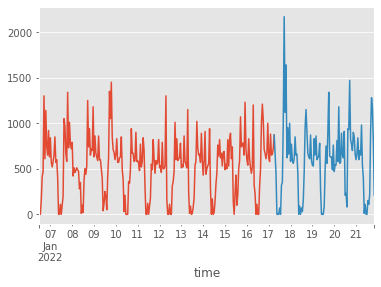

In [10]:
y_train = df_summary['power'][:int(0.7*len(df_summary))+1]
y_test = df_summary['power'][int(0.7*len(df_summary)):]
y_train.plot()
y_test.plot()

In [11]:
#최선 차분 수 파악
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 0


In [12]:
model = pm.auto_arima(y = y_train, max_d=2,start_p=0,
                     max_p = 3,
                     start_q = 0,
                     max_q = 3,
                     seasonal = True,
                     stepwise = True,
                     trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3722.578, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3613.243, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3656.875, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4072.494, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3608.843, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3607.095, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3609.062, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3609.050, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3637.493, Time=0.05 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 0.701 seconds


In [13]:
model.fit(y_train)

ARIMA(order=(3, 0, 0), scoring_args={}, suppress_warnings=True)

In [14]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  259
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -1798.548
Date:                Wed, 23 Feb 2022   AIC                           3607.095
Time:                        11:00:05   BIC                           3624.879
Sample:                             0   HQIC                          3614.246
                                - 259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    216.0004     41.941      5.150      0.000     133.798     298.203
ar.L1          0.5156      0.053      9.740      0.000       0.412       0.619
ar.L2          0.2128      0.065      3.256      0.0

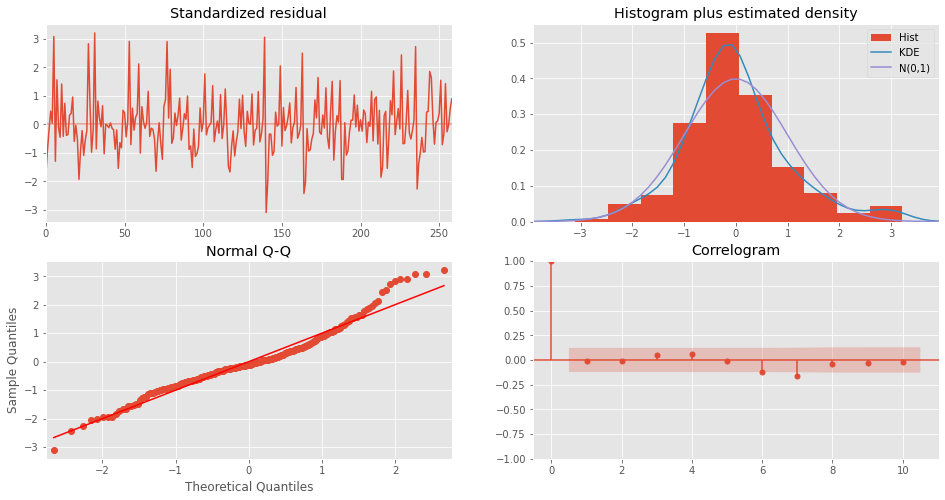

In [15]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

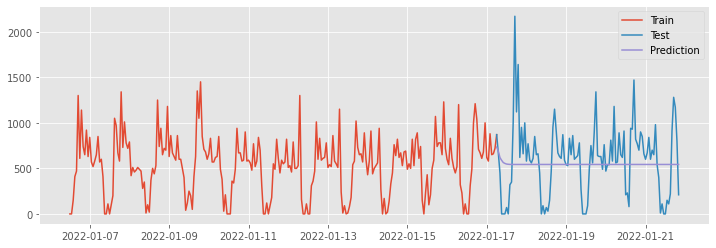

In [16]:
#테스트 데이터 개수만큼 예측
y_predict = model.predict(n_periods=len(y_test))
y_predict = pd.DataFrame(y_predict,index = y_test.index,columns=['Prediction'])

#그래프
fig, axes = plt.subplots(1,1,figsize= (12,4))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_predict, label='Prediction')
plt.legend()
plt.show()

In [17]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [18]:
model.predict(n_periods=1, return_conf_int=True)

(array([734.53346694]), array([[ 243.95595259, 1225.11098128]]))

In [19]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    
    #Update Model
    model.update(new_ob)

In [20]:
pd.DataFrame({"test" : y_test, "pred": y_pred})

,test,pred
time,,
2022-01-17 06:00:00,870.0,734.533467
2022-01-17 07:00:00,670.0,759.882828
2022-01-17 08:00:00,450.0,636.869930
2022-01-17 09:00:00,0.0,479.205956
2022-01-17 10:00:00,0.0,219.380260
...,...,...
2022-01-21 16:00:00,910.0,334.614503
2022-01-21 17:00:00,1280.0,745.478041
2022-01-21 18:00:00,1170.0,1109.616074


In [21]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  370
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -2589.820
Date:                Wed, 23 Feb 2022   AIC                           5189.640
Time:                        11:00:14   BIC                           5209.208
Sample:                             0   HQIC                          5197.412
                                - 370                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    216.0090     31.253      6.912      0.000     154.754     277.264
ar.L1          0.5629      0.036     15.666      0.000       0.492       0.633
ar.L2          0.2399      0.049      4.919      0.0

In [22]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(3,0,0)모형")
fig.show()

In [23]:
from statsmodels.tools.eval_measures import rmse
arima_rmse_error = rmse(y_test, y_pred)
arima_mse_error = arima_rmse_error**2

print(f'MSE: {arima_mse_error}\nRMSE: {arima_rmse_error}')

MSE: 87874.67146660815
RMSE: 296.43662301849304


In [30]:
from sklearn import metrics

def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    mae = round(metrics.mean_absolute_error(y_true, y_pred), 3)
    corr = round(np.corrcoef(y_true, y_pred)[0,1],3)
    mape = round(metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3)
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared=False), 3)
    rrmse = round(rmse / np.mean(y_true), 4)
    
    df = pd.DataFrame({
        'R2': r2,
        'MAE' : mae,
        'Corr' : corr,
        'RMSE' : rmse,
        'RRMSE' : rrmse,
        #'MAPE' : mape
    }, index=[0])
    return df

In [31]:
scoring(y_test, y_pred)

,R2,MAE,Corr,RMSE,RRMSE
0,41.586,225.198,0.646,296.437,0.4967
